In [1]:
import pandas as pd
# import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    RepeatedKFold,
    train_test_split,
    ParameterGrid,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet


import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from joblib import dump, load

from permetrics.regression import RegressionMetric

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-03 11:29:52.176645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
proj_dir = Path('../../..')
seed = 1993

In [3]:
ml_input_data = pd.read_csv(proj_dir / 'methods/04-ml_development/input_data/ml_input_data.csv')

In [4]:
# shuffle the data and divide into training and testing
ml_input_data = ml_input_data.sample(frac=1).reset_index(drop=True)
ml_input_data.dropna(subset=['LandTempC', 'NDVI', 'WaterTempC'], inplace=True)

# ml_input_data.sort_values(by='Date')


In [5]:
features = [
    "NDVI_scaled",
    "LandTempC_scaled",
    "ClimateClass_scaled",
    "DOY_scaled",
    # "WidthMin",
    "WidthMean_scaled",
    # "WidthMax",
    # "WaterTempC",
]
y1_col = "WaterTempC"
y_col = "avg_temp(C)"

In [7]:
model_name = "ANN1"

cv_splitter = RepeatedKFold(n_splits=5, 
                    n_repeats=10, 
                    random_state=seed
                    )

In [8]:
dev_set, test_set = train_test_split(ml_input_data, test_size=0.2, random_state=seed)

# add the data from the handpicked reaches to the test set
dev_set = dev_set[
    ~(
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    )
].copy()

test_set = pd.concat(
    [test_set, dev_set[
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    ]],
    
).copy()

## Model Development

In [9]:
class Block1HyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Define hyperparameters to tune
        hp_init_units = hp.Choice(
            "init_units",
            values=[8, 16, 32, 64, 128],
        )
        hp_learning_rate = hp.Choice(
            "learning_rate",
            values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
        )
        hp_activation = hp.Choice("activation", values=["linear", "relu"])
        hp_batch_size = hp.Choice(
            "batch_size",
            values=[8, 16, 32, 64, 128, 256, 512],
        )

        # First layer representing the residual (from block 1)
        l1_inputs = tf.keras.Input(shape=self.input_shape, name="l1_inputs")
        l1_outputs = tf.keras.layers.Dense(
            units=hp_init_units, activation=hp_activation, name="l1"
        )(l1_inputs)
        residual = tf.keras.Model(inputs=l1_inputs, outputs=l1_outputs, name="residual")

        # Stage 1 block
        stage1_input_shape = residual.output.shape[1]
        stage1_inputs = tf.keras.Input(shape=stage1_input_shape, name="stage1_inputs")

        x1 = tf.keras.layers.Dense(hp_init_units * 2)(stage1_inputs)
        x1 = tf.keras.layers.Dense(hp_init_units * 2**2)(x1)
        x1 = tf.keras.layers.Dense(hp_init_units * 2**2)(x1)
        x1 = tf.keras.layers.Dense(hp_init_units * 2)(x1)
        output1 = tf.keras.layers.Dense(1)(x1)

        stage1 = tf.keras.Model(inputs=stage1_inputs, outputs=output1, name="stage1")

        residual_output = residual(l1_inputs)
        stage1_output = stage1(residual_output)
        lsat_equiv_model = tf.keras.Model(
            inputs=l1_inputs, outputs=stage1_output, name="lsat_equiv"
        )

        lsat_equiv_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=["mse"],
        )

        return lsat_equiv_model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", values=[8, 16, 32, 64, 128, 256, 512]),
            **kwargs,
        )

In [10]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [11]:
block1_tuner = kt.Hyperband(
    hypermodel=Block1HyperModel(input_shape=(len(features),)),
    objective="val_loss",
    max_epochs=300,
    factor=3,
    hyperband_iterations=1,
    seed=seed,
    directory="ann_block1_tuning",
    project_name=model_name
)

In [12]:
X_dev = dev_set[features]
y1_dev = dev_set[y1_col]
y_dev = dev_set[y_col]

X_test = test_set[features]
y1_test = test_set[y1_col]
y_test = test_set[y_col]

In [13]:
block1_tuner.search(X_dev, y1_dev, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Trial 448 Complete [00h 00m 02s]
val_loss: 244.34237670898438

Best val_loss So Far: 3.9717228412628174
Total elapsed time: 00h 58m 09s


In [14]:
# get parameters and scores
trials = block1_tuner.oracle.get_best_trials(num_trials=100000)
hp_list = []
for trial in trials:
    hp_list.append(trial.hyperparameters.get_config()["values"] | {"Score": trial.score})

In [15]:
hp_df = pd.DataFrame(hp_list)
hp_df.to_csv(f"{model_name}_block1_tuner_results.csv", index=False)
best_block1_hp = block1_tuner.get_best_hyperparameters(num_trials=1)[0]

In [16]:
# save the best hyperparameters
with open(f"{model_name}_block1_best_hp.json", "w") as f:
    json.dump(best_block1_hp.values, f)

In [17]:
best_block1_model = block1_tuner.hypermodel.build(best_block1_hp)
history = best_block1_model.fit(X_dev, y1_dev, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1316/1316 [==============================] - 4s 3ms/step - loss: 8.8150 - mse: 8.8150 - val_loss: 5.3438 - val_mse: 5.3438
Epoch 2/100
1316/1316 [==============================] - 4s 3ms/step - loss: 5.8222 - mse: 5.8222 - val_loss: 5.5651 - val_mse: 5.5651
Epoch 3/100
1316/1316 [==============================] - 3s 3ms/step - loss: 5.4758 - mse: 5.4758 - val_loss: 5.0606 - val_mse: 5.0606
Epoch 4/100
1316/1316 [==============================] - 4s 3ms/step - loss: 5.1943 - mse: 5.1943 - val_loss: 4.7011 - val_mse: 4.7011
Epoch 5/100
1316/1316 [==============================] - 4s 3ms/step - loss: 5.0260 - mse: 5.0260 - val_loss: 5.1238 - val_mse: 5.1238
Epoch 6/100
1316/1316 [==============================] - 4s 3ms/step - loss: 4.9033 - mse: 4.9033 - val_loss: 4.4576 - val_mse: 4.4576
Epoch 7/100
1316/1316 [==============================] - 4s 3ms/step - loss: 4.8575 - mse: 4.8575 - val_loss: 4.7421 - val_mse: 4.7421
Epoch 8/100
1316/1316 [==============================] 

In [18]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
history_df["epoch"] = history_df["epoch"] + 1
history_df.to_csv(f"{model_name}block1_history.csv", index=False)

In [19]:
block1_pred = best_block1_model.predict(X_test)
list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]
block1_metrics = RegressionMetric(list(y1_test), list(block1_pred))
block1_metrics_df = pd.DataFrame(block1_metrics.get_metrics_by_list_names(list_metrics), index=[0])
block1_metrics_df.to_csv(f"{model_name}_block1_metrics.csv", index=False)

417/417 [==============================] - 0s 861us/step


In [20]:
# finally, train block 1 on the full dataset and save it
best_block1_model.fit(ml_input_data[features], ml_input_data[y1_col], epochs=100)
best_block1_model.save(f"{model_name}_block1.keras")

Epoch 1/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.4323 - mse: 4.4323
Epoch 2/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.3930 - mse: 4.3930
Epoch 3/100
2081/2081 [==============================] - 5s 3ms/step - loss: 4.3652 - mse: 4.3652
Epoch 4/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.3677 - mse: 4.3677
Epoch 5/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.3339 - mse: 4.3339
Epoch 6/100
2081/2081 [==============================] - 5s 3ms/step - loss: 4.3303 - mse: 4.3303
Epoch 7/100
2081/2081 [==============================] - 5s 3ms/step - loss: 4.3074 - mse: 4.3074
Epoch 8/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.2881 - mse: 4.2881
Epoch 9/100
2081/2081 [==============================] - 5s 3ms/step - loss: 4.3061 - mse: 4.3061
Epoch 10/100
2081/2081 [==============================] - 5s 2ms/step - loss: 4.3077 - mse: 4.3077
Epoch 11/100
2081/2

In [21]:
class InsituEquivHyperModel(kt.HyperModel):
    def __init__(
        self,
        input1_shape,
        #  input2_shape,
        block1_model,
    ):
        self.input1_shape = input1_shape
        # self.input2_shape = input2_shape
        self.block1_model = block1_model

    def build(self, hp):
        # Define hyperparameters to tune
        hp_init_units = hp.Choice("init_units", values=[8, 16, 32, 64, 128])
        hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        hp_activation = hp.Choice("activation", values=["linear", "relu"])
        hp_batch_size = hp.Choice("batch_size", values=[8, 16, 32, 64, 128, 256, 512])

        # First layer representing the residual (from block 1)
        input1 = tf.keras.Input(shape=self.input1_shape, name="input1")
        residual = self.block1_model.get_layer("residual")
        residual.trainable = False
        residual_output = residual(input1)

        # Stage 1 block
        stage1_ = self.block1_model.get_layer("stage1")
        stage1_.trainable = False
        stage1_output = stage1_(residual_output)

        # # First layer after reservoir inputs - input2
        # input2 = tf.keras.Input(shape=self.input2_shape, name="input2")
        # x2 = tf.keras.layers.Dense(units=hp_units, activation=hp_activation, name="x2")(
        #     input2
        # )

        # concatenate the residual, stage1_output, and x2
        # concat = tf.keras.layers.concatenate([residual_output, stage1_output, x2])
        concat = tf.keras.layers.concatenate([residual_output, stage1_output])

        output = tf.keras.layers.Dense(hp_init_units * 2)(concat)
        output = tf.keras.layers.Dense(hp_init_units * 2**2)(output)
        output = tf.keras.layers.Dense(hp_init_units * 2**2)(output)
        output = tf.keras.layers.Dense(hp_init_units * 2)(output)
        output = tf.keras.layers.Dense(1)(output)

        # output = tf.keras.layers.Dense(16)(concat)
        # output = tf.keras.layers.Dense(64)(output)
        # output = tf.keras.layers.Dense(64)(output)
        # output = tf.keras.layers.Dense(16)(output)
        # output = tf.keras.layers.Dense(1)(output)

        # insitu_equiv_model = tf.keras.Model(inputs=[input1, input2], outputs=output)
        insitu_equiv_model = tf.keras.Model(inputs=input1, outputs=output)

        insitu_equiv_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=["mse"],
        )

        return insitu_equiv_model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32, 64]),
            **kwargs,
        )

In [22]:
block2_tuner = kt.Hyperband(
    hypermodel=InsituEquivHyperModel(input1_shape=(len(features),), block1_model=best_block1_model),
    objective="val_loss",
    max_epochs=300,
    factor=3,
    hyperband_iterations=1,
    seed=seed,
    directory="ann_block2_tuning",
    project_name=model_name,
)

In [23]:
block2_tuner.search(X_dev, y_dev, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Trial 448 Complete [00h 00m 04s]
val_loss: 11.028447151184082

Best val_loss So Far: 3.4669570922851562
Total elapsed time: 01h 09m 57s


In [24]:
# get parameters and scores
block2_trials = block2_tuner.oracle.get_best_trials(num_trials=100000)
hp_list = []
for trial in block2_trials:
    hp_list.append(trial.hyperparameters.get_config()["values"] | {"Score": trial.score})

In [25]:
hp_df = pd.DataFrame(hp_list)
hp_df.to_csv(f"{model_name}_block2_tuner_results.csv", index=False)
best_block2_hp = block2_tuner.get_best_hyperparameters(num_trials=1)[0]

In [26]:
# save the best hyperparameters
with open(f"{model_name}_block2_best_hp.json", "w") as f:
    json.dump(best_block2_hp.values, f)

In [27]:
best_block2_model = block1_tuner.hypermodel.build(best_block1_hp)
history = best_block2_model.fit(X_dev, y_dev, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1316/1316 [==============================] - 4s 3ms/step - loss: 7.8185 - mse: 7.8185 - val_loss: 5.4363 - val_mse: 5.4363
Epoch 2/100
1316/1316 [==============================] - 4s 3ms/step - loss: 4.8346 - mse: 4.8346 - val_loss: 4.1516 - val_mse: 4.1516
Epoch 3/100
1316/1316 [==============================] - 4s 3ms/step - loss: 3.9915 - mse: 3.9915 - val_loss: 3.6341 - val_mse: 3.6341
Epoch 4/100
1316/1316 [==============================] - 4s 3ms/step - loss: 3.8389 - mse: 3.8389 - val_loss: 3.6759 - val_mse: 3.6759
Epoch 5/100
1316/1316 [==============================] - 4s 3ms/step - loss: 3.7156 - mse: 3.7156 - val_loss: 3.4383 - val_mse: 3.4383
Epoch 6/100
1316/1316 [==============================] - 4s 3ms/step - loss: 3.5841 - mse: 3.5841 - val_loss: 3.6550 - val_mse: 3.6550
Epoch 7/100
1316/1316 [==============================] - 4s 3ms/step - loss: 3.5030 - mse: 3.5030 - val_loss: 3.2168 - val_mse: 3.2168
Epoch 8/100
1316/1316 [==============================] 

In [28]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
history_df["epoch"] = history_df["epoch"] + 1
history_df.to_csv(f"{model_name}block1_history.csv", index=False)

In [29]:
block2_pred = best_block2_model.predict(X_test)
list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]
block2_metrics = RegressionMetric(list(y_test), list(block2_pred))
block2_metrics_df = pd.DataFrame(block2_metrics.get_metrics_by_list_names(list_metrics), index=[0])
block2_metrics_df.to_csv(f"{model_name}_block2_metrics.csv", index=False)

417/417 [==============================] - 0s 857us/step


In [30]:
# save best test set predictions vs actuals
test_set["block1_pred"] = block1_pred
test_set["block2_pred"] = block2_pred
test_set.to_csv(f"{model_name}_test_set.csv", index=False)

In [31]:
block1_evaluation = RegressionMetric(list(y1_test), list(block1_pred))
block2_evaluation = RegressionMetric(list(y_test), list(block2_pred))

block1_test_results = pd.DataFrame(block1_evaluation.get_metrics_by_list_names(list_metrics), index=[0])
block2_test_results = pd.DataFrame(block2_evaluation.get_metrics_by_list_names(list_metrics), index=[0])

block1_test_results.to_csv(f"{model_name}_block1_test_results.csv", index=False)
block2_test_results.to_csv(f"{model_name}_block2_test_results.csv", index=False)



In [32]:
block1_test_results[['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']].values

array([[1.41674772, 4.11649067, 2.02891367, 0.93168037, 0.93168037,
        0.95830576]])

In [33]:
mae, mse, rmse, r2, nse, kge = block1_test_results.iloc[0][['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']].values

Text(0.05, 0.65, 'KGE: 0.96')

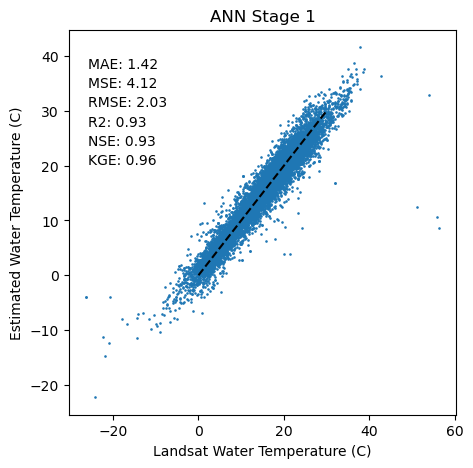

In [34]:
# scatter plot of the test results
fig, ax = plt.subplots(1,1, figsize=(5, 5))
test_set.plot.scatter(x='WaterTempC', y='block1_pred', ax=ax, s=.75)
ax.plot([0, 30], [0, 30], color='k', linestyle='--')
ax.set_xlabel('Landsat Water Temperature (C)')
ax.set_ylabel('Estimated Water Temperature (C)')
ax.set_title('ANN Stage 1')

mae, mse, rmse, r2, nse, kge = block1_test_results.iloc[0][['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']].values

ax.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
ax.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')
ax.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.8), xycoords='axes fraction')
ax.annotate(f'R2: {r2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
ax.annotate(f'NSE: {nse:.2f}', xy=(0.05, 0.7), xycoords='axes fraction')
ax.annotate(f'KGE: {kge:.2f}', xy=(0.05, 0.65), xycoords='axes fraction')

Text(0.05, 0.65, 'KGE: 0.92')

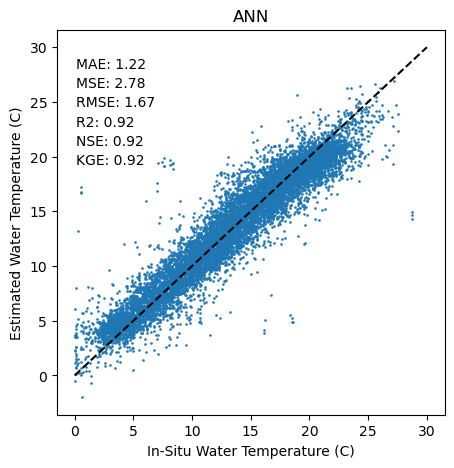

In [35]:
# scatter plot of the test results
fig, ax = plt.subplots(1,1, figsize=(5, 5))
test_set.plot.scatter(x='avg_temp(C)', y='block2_pred', ax=ax, s=.75)
ax.plot([0, 30], [0, 30], color='k', linestyle='--')
ax.set_xlabel('In-Situ Water Temperature (C)')
ax.set_ylabel('Estimated Water Temperature (C)')
ax.set_title('ANN')
# ax.set_title('ANN Stage 2')

mae, mse, rmse, r2, nse, kge = block2_test_results.iloc[0][['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']].values

ax.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
ax.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')
ax.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.8), xycoords='axes fraction')
ax.annotate(f'R2: {r2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
ax.annotate(f'NSE: {nse:.2f}', xy=(0.05, 0.7), xycoords='axes fraction')
ax.annotate(f'KGE: {kge:.2f}', xy=(0.05, 0.65), xycoords='axes fraction')

In [36]:
# finally, train block 2 on the full dataset and save it
best_block2_model.fit(ml_input_data[features], ml_input_data[y_col], epochs=100)
best_block2_model.save(f"{model_name}_block2.keras")

Epoch 1/100
2081/2081 [==============================] - 6s 3ms/step - loss: 2.9083 - mse: 2.9083
Epoch 2/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.8595 - mse: 2.8595
Epoch 3/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.8135 - mse: 2.8135
Epoch 4/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.7815 - mse: 2.7815
Epoch 5/100
2081/2081 [==============================] - 6s 3ms/step - loss: 2.7659 - mse: 2.7659
Epoch 6/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.7348 - mse: 2.7348
Epoch 7/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.7219 - mse: 2.7219
Epoch 8/100
2081/2081 [==============================] - 6s 3ms/step - loss: 2.7214 - mse: 2.7214
Epoch 9/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.6971 - mse: 2.6971
Epoch 10/100
2081/2081 [==============================] - 5s 3ms/step - loss: 2.7002 - mse: 2.7002
Epoch 11/100
2081/2